In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from hmmlearn import hmm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import functions_data_processing as fsd
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from itertools import combinations
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import TimeSeriesSplit
import random
from sklearn.model_selection import StratifiedKFold

In [2]:
# This cell changes the values of the df.csv file in order for the absent state to have a value of 0 instead of 0.1 and the present state to have a value of 1 instead of 0.9
# Furthermore it adds a new column in which we have both values of Microwave and Default combined

df_imported = pd.read_csv('df.csv', index_col=0)
df_imported = df_imported
df_imported.index = pd.to_datetime(df_imported.index)
df = pd.DataFrame()
df['Microwave'] = df_imported['Microwave']
df['Default'] = df_imported['Default']
df['Ground Truth'] = df_imported['Ground Truth']
df['Microwave - Default (combined)'] = 'temporary'
df['Garage door'] = df_imported['Garage door']

df =df.mask(df==0.9, 1)
df =df.mask(df==0.1, 0)

mask1 = (df['Microwave']==1.0) & (df['Default']==1.0)
mask2 = (df['Microwave']==0.0) & (df['Default']==1.0)
mask3 = (df['Microwave']==0.0) & (df['Default']==0.0)
mask4 = (df['Microwave']==1.0) & (df['Default']==0.0)

df['Microwave - Default (combined)'] = ''
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask1, '11')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask2, '01')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask3, '00')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask4, '10')
df.iloc[:1025]



,Microwave,Default,Ground Truth,Microwave - Default (combined),Garage door
2016-01-01 05:00:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:01:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:02:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:03:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:04:00,0.0,1.0,1.0,01,0.0
...,...,...,...,...,...
2016-01-01 22:00:00,0.0,1.0,1.0,01,0.0
2016-01-01 22:01:00,0.0,1.0,1.0,01,0.0
2016-01-01 22:02:00,0.0,1.0,1.0,01,0.0
2016-01-01 22:03:00,0.0,1.0,1.0,01,0.0


In [3]:
# A function that selects a section of the data frame based on a starting date and interval

def interval_model(data_frame, starting_date, interval):
    
    s_date = pd.to_datetime(starting_date, format='%Y-%m-%d %H:%M:%S.%f')
    data_frame = data_frame.loc[s_date : s_date + interval]
    return data_frame
   


In [4]:
# An example of using the function interval_model defined above
df_model = df['Microwave - Default (combined)']

df_model = interval_model(data_frame= df_model, starting_date='2016-02-01 05:00:00', interval=datetime.timedelta(days=7))

df_model.iloc[:]



2016-02-01 05:00:00    01
2016-02-01 05:01:00    01
2016-02-01 05:02:00    01
2016-02-01 05:03:00    01
2016-02-01 05:04:00    01
                       ..
2016-02-08 04:56:00    01
2016-02-08 04:57:00    01
2016-02-08 04:58:00    01
2016-02-08 04:59:00    01
2016-02-08 05:00:00    01
Name: Microwave - Default (combined), Length: 10081, dtype: object

In [5]:


def plot_dfs(data_frame, attributes, graphing_interval, y_label, title):
    start_date = pd.to_datetime(graphing_interval[0])
    end_date = pd.to_datetime(graphing_interval[1])

    sliced_df = data_frame.loc[start_date:end_date, attributes]
    plt.figure(figsize=(10, 5))
    plt.xticks(rotation=45) 

    sns.lineplot(data=sliced_df)
    plt.xlabel('Time')
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [6]:
#time = range(len(state_ests))
#ests_df = pd.DataFrame(data=state_ests[:500], index=df.index[:500], columns=['Presence'])
#g = sns.lineplot(data=ests_df).set(title='Estimated presence')



In [7]:

#Markov Chain - 1 (with aggregation)

'''
y_pred_proba_all = []
y_true_all = []

model.n_features = len(o_states)
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs


fig, ax = plt.subplots(figsize=(5, 5))

for split_number, (train_index, test_index) in enumerate(ss.split(data, y_true)):
    model.startprob_ = start_probs
    print("Split:", split_number)
    
    
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]

    # Fit the model and predict probabilities for the test set
    model.fit(X_train)
    logprob, state_ests = model.decode(X_test)

    y_pred_proba = state_ests
    y_pred_proba_all.extend(y_pred_proba)
    y_true_all.extend(y_true[test_index])


    print(confusion_matrix(y_true[test_index], y_pred_proba))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))



# Plot the ROC curve
#plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

'''




'\ny_pred_proba_all = []\ny_true_all = []\n\nmodel.n_features = len(o_states)\nmodel.transmat_ = trans_mat\nmodel.emissionprob_ = emission_probs\n\n\nfig, ax = plt.subplots(figsize=(5, 5))\n\nfor split_number, (train_index, test_index) in enumerate(ss.split(data, y_true)):\n    model.startprob_ = start_probs\n    print("Split:", split_number)\n    \n    \n    X_train, X_test = data[train_index], data[test_index]\n    y_train, y_test = y_true[train_index], y_true[test_index]\n\n    # Fit the model and predict probabilities for the test set\n    model.fit(X_train)\n    logprob, state_ests = model.decode(X_test)\n\n    y_pred_proba = state_ests\n    y_pred_proba_all.extend(y_pred_proba)\n    y_true_all.extend(y_true[test_index])\n\n\n    print(confusion_matrix(y_true[test_index], y_pred_proba))\n\n    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)\n    auc_score = roc_auc_score(y_test, y_pred_proba)\n\n    # Plot the ROC curve for the current fold\n    ax.plot(fpr, tpr, label=\'Fold {}  (A

Daily cross validation (no aggregation) 

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


[0 1 0 0]
(10081, 4)
[6, 1, 5, 2, 4]
[3, 7]
0
[1 1 1 ... 1 1 1]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[ 960    0]
 [ 360 1560]]
Learned emission probs:
[[9.97878788e-01 1.17534473e-13 2.12121212e-03 2.13596107e-25]
 [2.20976918e-12 9.95128205e-01 7.07853847e-27 4.87179487e-03]]
------------------------------------
Learned transition matrix:
[[0.99848485 0.00151515]
 [0.00128238 0.99871762]]
1
[1 1 1 ... 1 1 1]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[ 960    0]
 [ 360 1560]]
Learned emission probs:
[[9.97878788e-01 1.09129673e-18 2.12121212e-03 1.13206010e-36]
 [1.46157134e-17 9.95128205e-01 1.92496135e-38 4.87179487e-03]]
------------------------------------
Learned transition matrix:
[[0.99848485 0.00151515]
 [0.00128238 0.99871762]]
2
[1 1 1 ... 1 1 1]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[ 960    0]
 [ 360 1560]]
Learned emission probs:
[[9.97878788e-01 1.01325894e-23 2.12121212e-03 5.99992248e-48]
 [9.66703134e-23 9.95128205e-01 5.23480405e

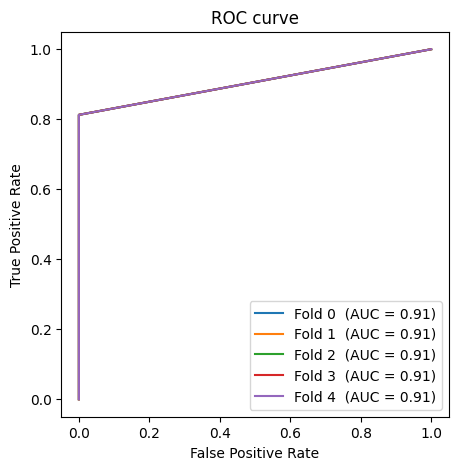

In [8]:
#Markov Chain - 2 (without aggregation) - specific cross validation

y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))


y_true_all_2 = []

y_pred_proba_all_2 = []
y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.5, 0.5])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.1, 0.4, 0.25],
                           [0.2, 0.5, 0.1, 0.2]])

# Transition matrix of hidden states
trans_mat = np.array([[0.95, 0.05], [0.05, 0.95]])

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])


print(data[0])


# Build the model
# Set up model:
model = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1, init_params='',)

model.n_features = len(o_states)

model.startprob_ = start_probs
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs




x = data
y = y_true_original.to_numpy()

fig, ax = plt.subplots(figsize=(5, 5))

'''

for split_number, (train_index, test_index) in enumerate(ss.split(x, y)):
    
    print("Split:", split_number)

    #print("Start: ", model.startprob_, "Transmission: ", model.transmat_, "Emission :", model.emissionprob_)
    
    
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Train:", train_index)
    print("Test", test_index)

    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model.fit(X_train)
    logprob, state_ests = model.decode(X_test)

    y_pred_proba = state_ests
    y_pred_proba_all_2.extend(y_pred_proba)
    y_true_all_2.extend(y_true_original[test_index])


    

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(confusion_matrix(y[test_index], y_pred_proba))

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))

    

    print("Learned emission probs:")
    print(model.emissionprob_)
    print('------------------------------------')
    print("Learned transition matrix:")
    print(model.transmat_)

    

# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

'''


print(x.shape)
train_days = 5
test_days = 2

# Calculate the total number of minutes in the data
total_minutes = len(x)

day = 24*60
n_splits = 5


random_numbers = random.sample(list(range(1,8)), 5)

not_included = [num for num in list(range(1,8)) if num not in random_numbers]

print(random_numbers)
print(not_included)

for n in range(n_splits):
    print(n)


    start = random_numbers[0]
    X_train = x[(start-1)*day:start*day]
    y_train = y[(start-1)*day:start*day]

    start_not = not_included[0]
    X_test = x[(start_not-1)*day:start_not*day]
    y_test = y[(start_not-1)*day:start_not*day]


    # Perform the train-test split
    for i in random_numbers[1:]:
        X_train = np.vstack((X_train, x[(i-1)*day:i*day]))
        y_train = np.vstack((y_train, y[(i-1)*day:i*day]))

    for i in not_included[1:]:
        X_test = np.vstack((X_test, x[(i-1)*day:i*day]))
        y_test = np.vstack((y_test, y[(i-1)*day:i*day]))

    # Convert the data to the desired type
    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model.fit(X_train)
    logprob, state_ests = model.decode(X_test)

    y_pred_proba = state_ests

    print(state_ests)
    print(y_test)


    # Compute ROC curve and AUC score
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(np.ravel(y_test), y_pred_proba)

    auc_score = roc_auc_score(np.ravel(y_test), y_pred_proba)


    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(n, round(auc_score, 2)))

    # Print confusion matrix
    y_pred = np.round(y_pred_proba)
    print(confusion_matrix(np.ravel(y_test), np.ravel(y_pred)))

    print("Learned emission probs:")
    print(model.emissionprob_)
    print('------------------------------------')
    print("Learned transition matrix:")
    print(model.transmat_)




# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()







Random cross validation (no aggregation)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Split: 0
Train: [4129  652 9946 ... 7969 6527 5188]
Test [ 628 9341 9392 ... 3812 9613 6016]
[[ 291  745]
 [  89 1900]]
Learned emission probs:
[[4.83755969e-01 5.12419275e-01 6.58021382e-04 3.16673443e-03]
 [4.28843994e-01 5.67862632e-01 4.86106034e-04 2.80726813e-03]]
------------------------------------
Learned transition matrix:
[[0.46999331 0.53000669]
 [0.46988539 0.53011461]]
Split: 1
Train: [1129 7751 7024 ... 7750 9421 5022]
Test [ 6690 10024  1398 ...  4423  2027  1261]
[[ 753  276]
 [ 283 1713]]
Learned emission probs:
[[0.48373595 0.51164439 0.00115147 0.00346818]
 [0.42885559 0.56721899 0.00085071 0.00307471]]
------------------------------------
Learned transition matrix:
[[0.47006057 0.52993943]
 [0.46995679 0.53004321]]
Split: 2
Train: [5217 5802 6621 ... 9059 6464 3651]
Test [2101 5448 7999 ...  352 3320 9751]
[[1022    1]
 [ 376 1626]]
Learned emission probs:
[[0.48550911 0.50985785 0.00131587 0.00331717]
 [0.43048134 0.56560525 0.00097226 0.00294115]]
---------------

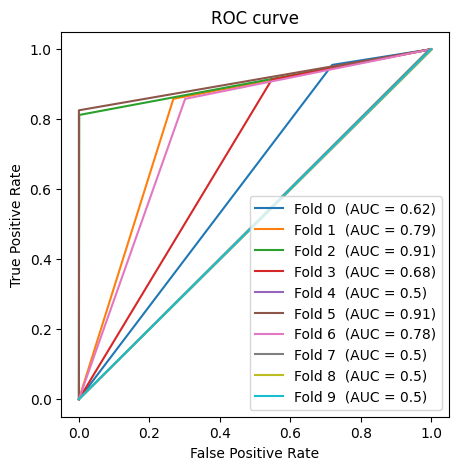

In [9]:
#Markov Chain - 2 (without aggregation) - random cross validation


y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))
ss = ShuffleSplit(n_splits=10, test_size=0.3)

y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.5, 0.5])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.2, 0.3, 0.25],
                           [0.25, 0.25, 0.25, 0.25]])

# Transition matrix of hidden states
trans_mat = np.array([[0.5, 0.5], [0.5, 0.5]])

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])



# Build the model
# Set up model:
model_2 = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1, init_params='')

model_2.n_features = len(o_states)


model_2.startprob_ = start_probs
model_2.transmat_ = trans_mat
model_2.emissionprob_ = emission_probs




x = data
y = y_true_original.to_numpy()

fig, ax = plt.subplots(figsize=(5, 5))



for split_number, (train_index, test_index) in enumerate(ss.split(x, y)):
    
    print("Split:", split_number)

    #print("Start: ", model.startprob_, "Transmission: ", model.transmat_, "Emission :", model.emissionprob_)
    
    
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Train:", train_index)
    print("Test", test_index)

    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model_2.fit(X_train)
    logprob, state_ests = model_2.decode(X_test)

    y_pred_proba = state_ests

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(confusion_matrix(y[test_index], y_pred_proba))

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))

    

    print("Learned emission probs:")
    print(model_2.emissionprob_)
    print('------------------------------------')
    print("Learned transition matrix:")
    print(model_2.transmat_)

    

# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()






In [10]:
print(len(X_train))

7056


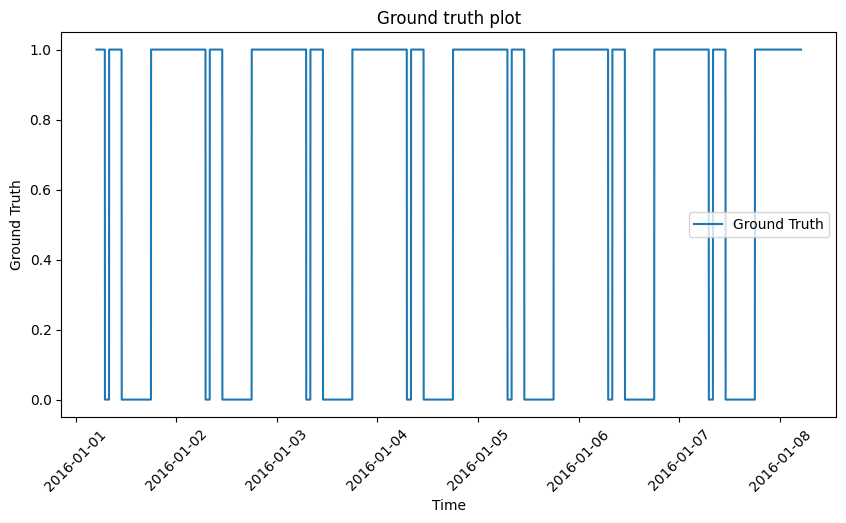

In [11]:
plot_dfs(y_true_original.to_frame(), ['Ground Truth'], [y_true_original.index[0], y_true_original.index[-1]], y_label="Ground Truth", title = "Ground truth plot")

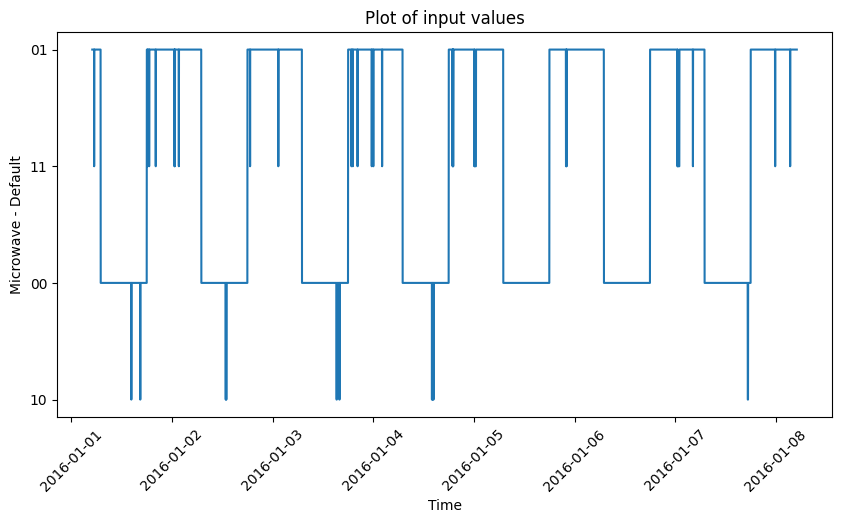

In [12]:
plot_dfs(df, 'Microwave - Default (combined)', [y_true_original.index[0], y_true_original.index[-1]], y_label="Microwave - Default", title = "Plot of input values")

In [13]:
df['Microwave - Default (combined)'].index[-1]

Timestamp('2016-12-16 03:29:00')

3360 6721


Text(0.5, 1.0, 'Linear kernel for SVM')

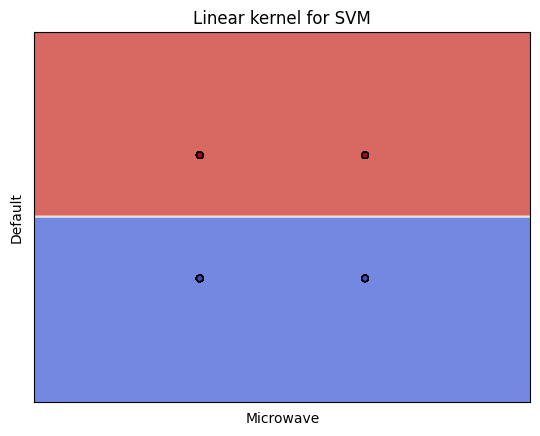

In [14]:
# SVM

df_temp = interval_model(data_frame= df, starting_date='2016-01-21 05:00:00', interval=datetime.timedelta(days=7))

ss = ShuffleSplit(n_splits=7, test_size=0.3)

classifier = svm.SVC(kernel="linear", C=1)
# Predicts whether someone is present or absent 
# Inputs: Micorwave, Default

x = np.zeros([10081, 2])
x[:,0] = df_temp['Microwave']
x[:,1] = df_temp['Default']

y = np.zeros([10081,1])
y = df_temp['Ground Truth']

absent =0
present =0

absent = np.count_nonzero(y == 0)
present = np.count_nonzero(y == 1)

print(absent, present)

data = classifier.fit(x,y)

fig, sub = plt.subplots()
ax = sub
title = "Linear kernel for SVM"

disp = DecisionBoundaryDisplay.from_estimator(
        data,
        x,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="Microwave",
        ylabel="Default",
    )
ax.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)







In [15]:
df_temp.head(5)

,Microwave,Default,Ground Truth,Microwave - Default (combined),Garage door
2016-01-21 05:00:00,0.0,1.0,1.0,01,0.0
2016-01-21 05:01:00,0.0,1.0,1.0,01,0.0
2016-01-21 05:02:00,0.0,1.0,1.0,01,0.0
2016-01-21 05:03:00,0.0,1.0,1.0,01,0.0
2016-01-21 05:04:00,0.0,1.0,1.0,01,0.0


Fold: 0 
 [[1020    0]
 [ 367 1638]]
Fold: 1 
 [[1017    0]
 [ 355 1653]]
Fold: 2 
 [[1017    0]
 [ 356 1652]]
Fold: 3 
 [[1007    0]
 [ 404 1614]]
Fold: 4 
 [[1004    0]
 [ 374 1647]]
Fold: 5 
 [[1083    0]
 [ 350 1592]]
Fold: 6 
 [[1023    0]
 [ 345 1657]]


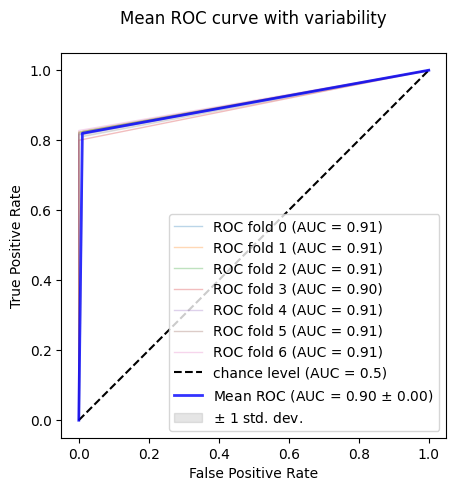

In [16]:
ss = ShuffleSplit(n_splits=7, test_size=0.3)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(5, 5))

for fold, (train, test) in enumerate(ss.split(x,y)):
    classifier.fit(x[train],y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        x[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    print("Fold:", fold, "\n", confusion_matrix(y[test], classifier.predict(x[test])))


ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.show()
    

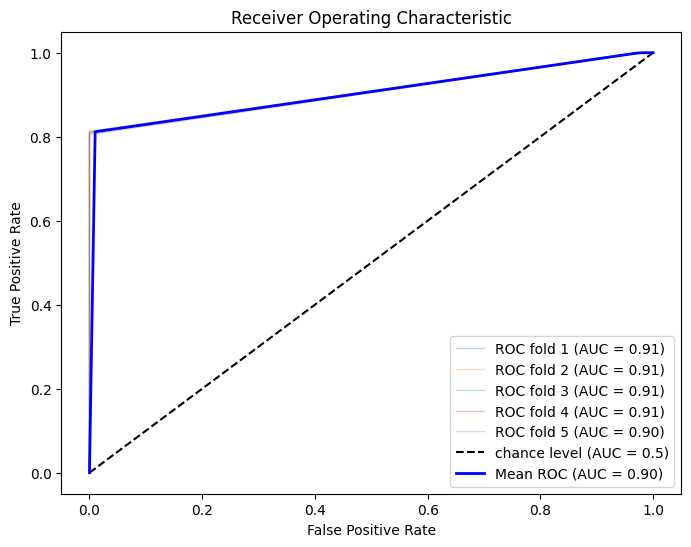

In [17]:
# SVM


ss = ShuffleSplit(n_splits=5, test_size=0.3)
classifier = svm.SVC(kernel="linear", C=1, probability=True)
x = np.zeros([10081, 3])
x[:, 0] = df_temp['Microwave']
x[:, 1] = df_temp['Default']
x[:, 2] = df_temp['Garage door']

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(8, 6))

for fold, (train, test) in enumerate(ss.split(x, y)):
    classifier.fit(x[train], y[train])
    y_score = classifier.predict_proba(x[test])[:, 1]

    fpr, tpr, _ = roc_curve(y[test], y_score)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(roc_auc)

    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f"ROC fold {fold + 1} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color="b", label=f"Mean ROC (AUC = {mean_auc:.2f})", lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()



[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Fold: 0 
 [[480   0]
 [189 772]]
Fold: 1 
 [[480   0]
 [179 781]]
Fold: 2 
 [[480   0]
 [171 789]]
Fold: 3 
 [[480   0]
 [181 779]]
Fold: 4 
 [[480   0]
 [189 771]]
Fold: 5 
 [[480   0]
 [171 789]]
Fold: 6 
 [[480   0]
 [180 780]]


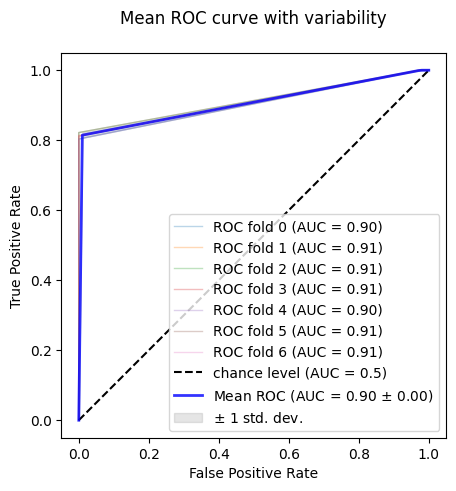

In [18]:
ss = ShuffleSplit(n_splits=7, test_size=0.3)

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=2)

print(x)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(5, 5))

for fold, (train, test) in enumerate(skf.split(x,y)):
    classifier.fit(x[train],y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        x[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    print("Fold:", fold, "\n", confusion_matrix(y[test], classifier.predict(x[test])))


ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.show()

Same day context recognition - SVM

Fold: 0 
 [[480   0]
 [180 780]]
Fold: 1 
 [[480   0]
 [180 780]]
Fold: 2 
 [[480   0]
 [180 780]]
Fold: 3 
 [[480   0]
 [180 780]]
Fold: 4 
 [[480   0]
 [180 780]]
Fold: 5 
 [[480   0]
 [180 780]]
Fold: 6 
 [[480   0]
 [180 780]]


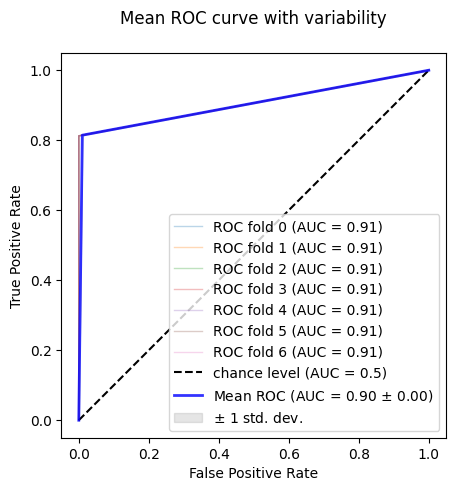

In [19]:

df_t = interval_model(data_frame= df, starting_date='2016-02-01 05:00:00', interval=datetime.timedelta(days=14))


day = 24*60

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(5, 5))


x = np.zeros([20161, 2])
x[:, 0] = df_t['Microwave']
x[:, 1] = df_t['Default']


y = np.zeros([20161,1])
y = df_t['Ground Truth']


for fold in range(7):


    # Training data (first 24 hours)
    start_train = fold
    end_train = start_train +1
    X_train = x[start_train * day :end_train * day]
    y_train = y[start_train * day :end_train * day]

    # Testing data (a week later)
    start_test = 7 + start_train
    end_test = start_test + 1
    X_test = x[start_test * day :end_test  * day]
    y_test = y[start_test * day :end_test  * day]


    classifier.fit(X_train, y_train)
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    print("Fold:", fold, "\n", confusion_matrix(y[test], classifier.predict(x[test])))


ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.show()



In [20]:
df_t.head(5)

,Microwave,Default,Ground Truth,Microwave - Default (combined),Garage door
2016-02-01 05:00:00,0.0,1.0,1.0,01,0.0
2016-02-01 05:01:00,0.0,1.0,1.0,01,0.0
2016-02-01 05:02:00,0.0,1.0,1.0,01,0.0
2016-02-01 05:03:00,0.0,1.0,1.0,01,0.0
2016-02-01 05:04:00,0.0,1.0,1.0,01,0.0
